In [1]:
import sys
sys.path.append("../") 

In [2]:
import argparse, time, logging, random, math

import numpy as np
import mxnet as mx

from mxnet import gluon, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.,1.)
])

In [4]:
num_gpus = 1
model_ctx = mx.cpu()

num_workers = 8
batch_size = 64 
train_data = gluon.data.DataLoader(
    gluon.data.vision.MNIST(train=True).transform_first(transform),
    batch_size=batch_size, shuffle=True, last_batch='discard', num_workers=num_workers)

val_data = gluon.data.DataLoader(
    gluon.data.vision.MNIST(train=False).transform_first(transform),
    batch_size=batch_size, shuffle=False, num_workers=num_workers)

[15:31:29] /home/proyecto/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


In [5]:
for X,y in train_data:
    print(X.shape)
    print(y.shape)
    break

(64, 1, 28, 28)
(64,)


### Bayesian inference for MNIST

* [Stochastic Gradient Descent](#chapter1)
* [Stochastic Gradient Langevin Dynamics](#chapter2)
* [Bayes By Backprop](#chapter3)
* [Diagnostics](#chapter4)


# Stochastic Gradient Descent <a class="anchor" id="chapter1"></a>

In [6]:
import mxnet as mx
from mxnet import nd, autograd, gluon
hyper={'alpha':10.}
in_units=(28,28)
out_units=10

In [13]:
import mxnet as mx
from hamiltonian.inference.sgd import sgd
from hamiltonian.models.softmax import softmax

model=softmax(hyper,in_units,out_units,ctx=model_ctx)
inference=sgd(model,model.par,step_size=0.001,ctx=model_ctx)

In [14]:
import hamiltonian
import importlib

try:
    importlib.reload(hamiltonian.models.softmax)
    importlib.reload(hamiltonian.inference.sgd)
    print('modules re-loaded')
except:
    print('no modules loaded yet')


modules re-loaded


In [15]:
par,loss=inference.fit(epochs=20,batch_size=batch_size,data_loader=train_data,verbose=True)

  5%|██▏                                         | 1/20 [00:33<10:44, 33.91s/it]

loss: 1.0538


 15%|██████▌                                     | 3/20 [01:57<11:17, 39.88s/it]

loss: 0.5362


 15%|██████▌                                     | 3/20 [02:03<11:38, 41.11s/it]


KeyboardInterrupt: 

In [19]:
model.net.collect_params()

{'1.weight': Parameter (shape=(10, 784), dtype=float32),
 '1.bias': Parameter (shape=(10,), dtype=float32)}

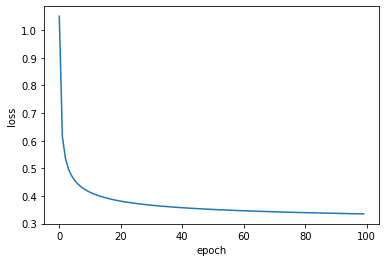

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 360
sns.set_style("whitegrid")


fig=plt.figure(figsize=[5,5])
plt.plot(loss,color='blue',lw=3)
plt.xlabel('Epoch', size=18)
plt.ylabel('Loss', size=18)
plt.title('SGD Softmax MNIST', size=18)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()
plt.savefig('sgd_softmax.pdf', bbox_inches='tight')

In [22]:
model.net.save_parameters('softmax_sgd_100_epochs.params')

In [9]:
model.net.load_parameters('softmax_sgd_100_epochs.params',ctx=model_ctx)
par=dict()
for name,gluon_par in model.net.collect_params().items():
    par.update({name:gluon_par.data()})
               

In [10]:
total_samples,total_labels=inference.predict(par,batch_size=batch_size,num_samples=10,data_loader=val_data)

In [11]:
y_hat=np.quantile(total_samples,.5,axis=0)

In [12]:
from sklearn.metrics import classification_report

print(classification_report(np.int32(total_labels),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       979
           1       0.97      0.97      0.97      1133
           2       0.92      0.88      0.90      1030
           3       0.90      0.89      0.89      1008
           4       0.88      0.91      0.90       980
           5       0.84      0.85      0.84       890
           6       0.88      0.94      0.91       956
           7       0.91      0.92      0.91      1027
           8       0.85      0.84      0.85       973
           9       0.93      0.85      0.89      1008

    accuracy                           0.90      9984
   macro avg       0.90      0.90      0.90      9984
weighted avg       0.90      0.90      0.90      9984



# Stochastic Gradient Langevin Dynamics <a class="anchor" id="chapter2"></a>

In [7]:
from hamiltonian.inference.sgld import sgld
from hamiltonian.models.softmax import lenet

in_units = (28,28)
model=lenet(hyper,in_units,out_units,ctx=model_ctx)
inference=sgld(model,model.par,step_size=0.01,ctx=model_ctx)

In [8]:
import hamiltonian
import importlib

try:
    importlib.reload(hamiltonian.models.lenet)
    importlib.reload(hamiltonian.inference.sgld)
    print('modules re-loaded')
except:
    print('no modules loaded yet')

no modules loaded yet


In [9]:
loss,posterior_samples=inference.sample(epochs=10,batch_size=batch_size,
                             data_loader=train_data,
                             verbose=True)

 10%|████▍                                       | 1/10 [01:09<10:28, 69.80s/it]

loss: 1.0137


 20%|████████▊                                   | 2/10 [02:21<09:26, 70.75s/it]

loss: 0.8137


 30%|█████████████▏                              | 3/10 [03:25<07:55, 67.96s/it]

loss: 0.7674


 40%|█████████████████▌                          | 4/10 [04:43<07:10, 71.74s/it]

loss: 0.7297


 50%|██████████████████████                      | 5/10 [05:54<05:56, 71.38s/it]

loss: 0.6981


 60%|██████████████████████████▍                 | 6/10 [07:04<04:44, 71.07s/it]

loss: 0.6768


 70%|██████████████████████████████▊             | 7/10 [08:18<03:35, 71.91s/it]

loss: 0.6706


 80%|███████████████████████████████████▏        | 8/10 [09:31<02:24, 72.31s/it]

loss: 0.6662


 90%|███████████████████████████████████████▌    | 9/10 [10:39<01:11, 71.03s/it]

loss: 0.6453


100%|███████████████████████████████████████████| 10/10 [11:49<00:00, 70.95s/it]


loss: 0.6360


 10%|████▍                                       | 1/10 [01:05<09:53, 65.93s/it]

loss: 1.0206


 20%|████████▊                                   | 2/10 [02:15<09:04, 68.09s/it]

loss: 0.8173


 30%|█████████████▏                              | 3/10 [03:26<08:06, 69.43s/it]

loss: 0.7698


 40%|█████████████████▌                          | 4/10 [04:43<07:14, 72.33s/it]

loss: 0.7418


 50%|██████████████████████                      | 5/10 [05:50<05:52, 70.47s/it]

loss: 0.7045


 60%|██████████████████████████▍                 | 6/10 [07:03<04:45, 71.38s/it]

loss: 0.6687


 70%|██████████████████████████████▊             | 7/10 [08:10<03:29, 69.78s/it]

loss: 0.6603


 80%|███████████████████████████████████▏        | 8/10 [09:19<02:18, 69.49s/it]

loss: 0.6522


 90%|███████████████████████████████████████▌    | 9/10 [10:27<01:09, 69.05s/it]

loss: 0.6420


100%|███████████████████████████████████████████| 10/10 [11:37<00:00, 69.79s/it]

loss: 0.6289


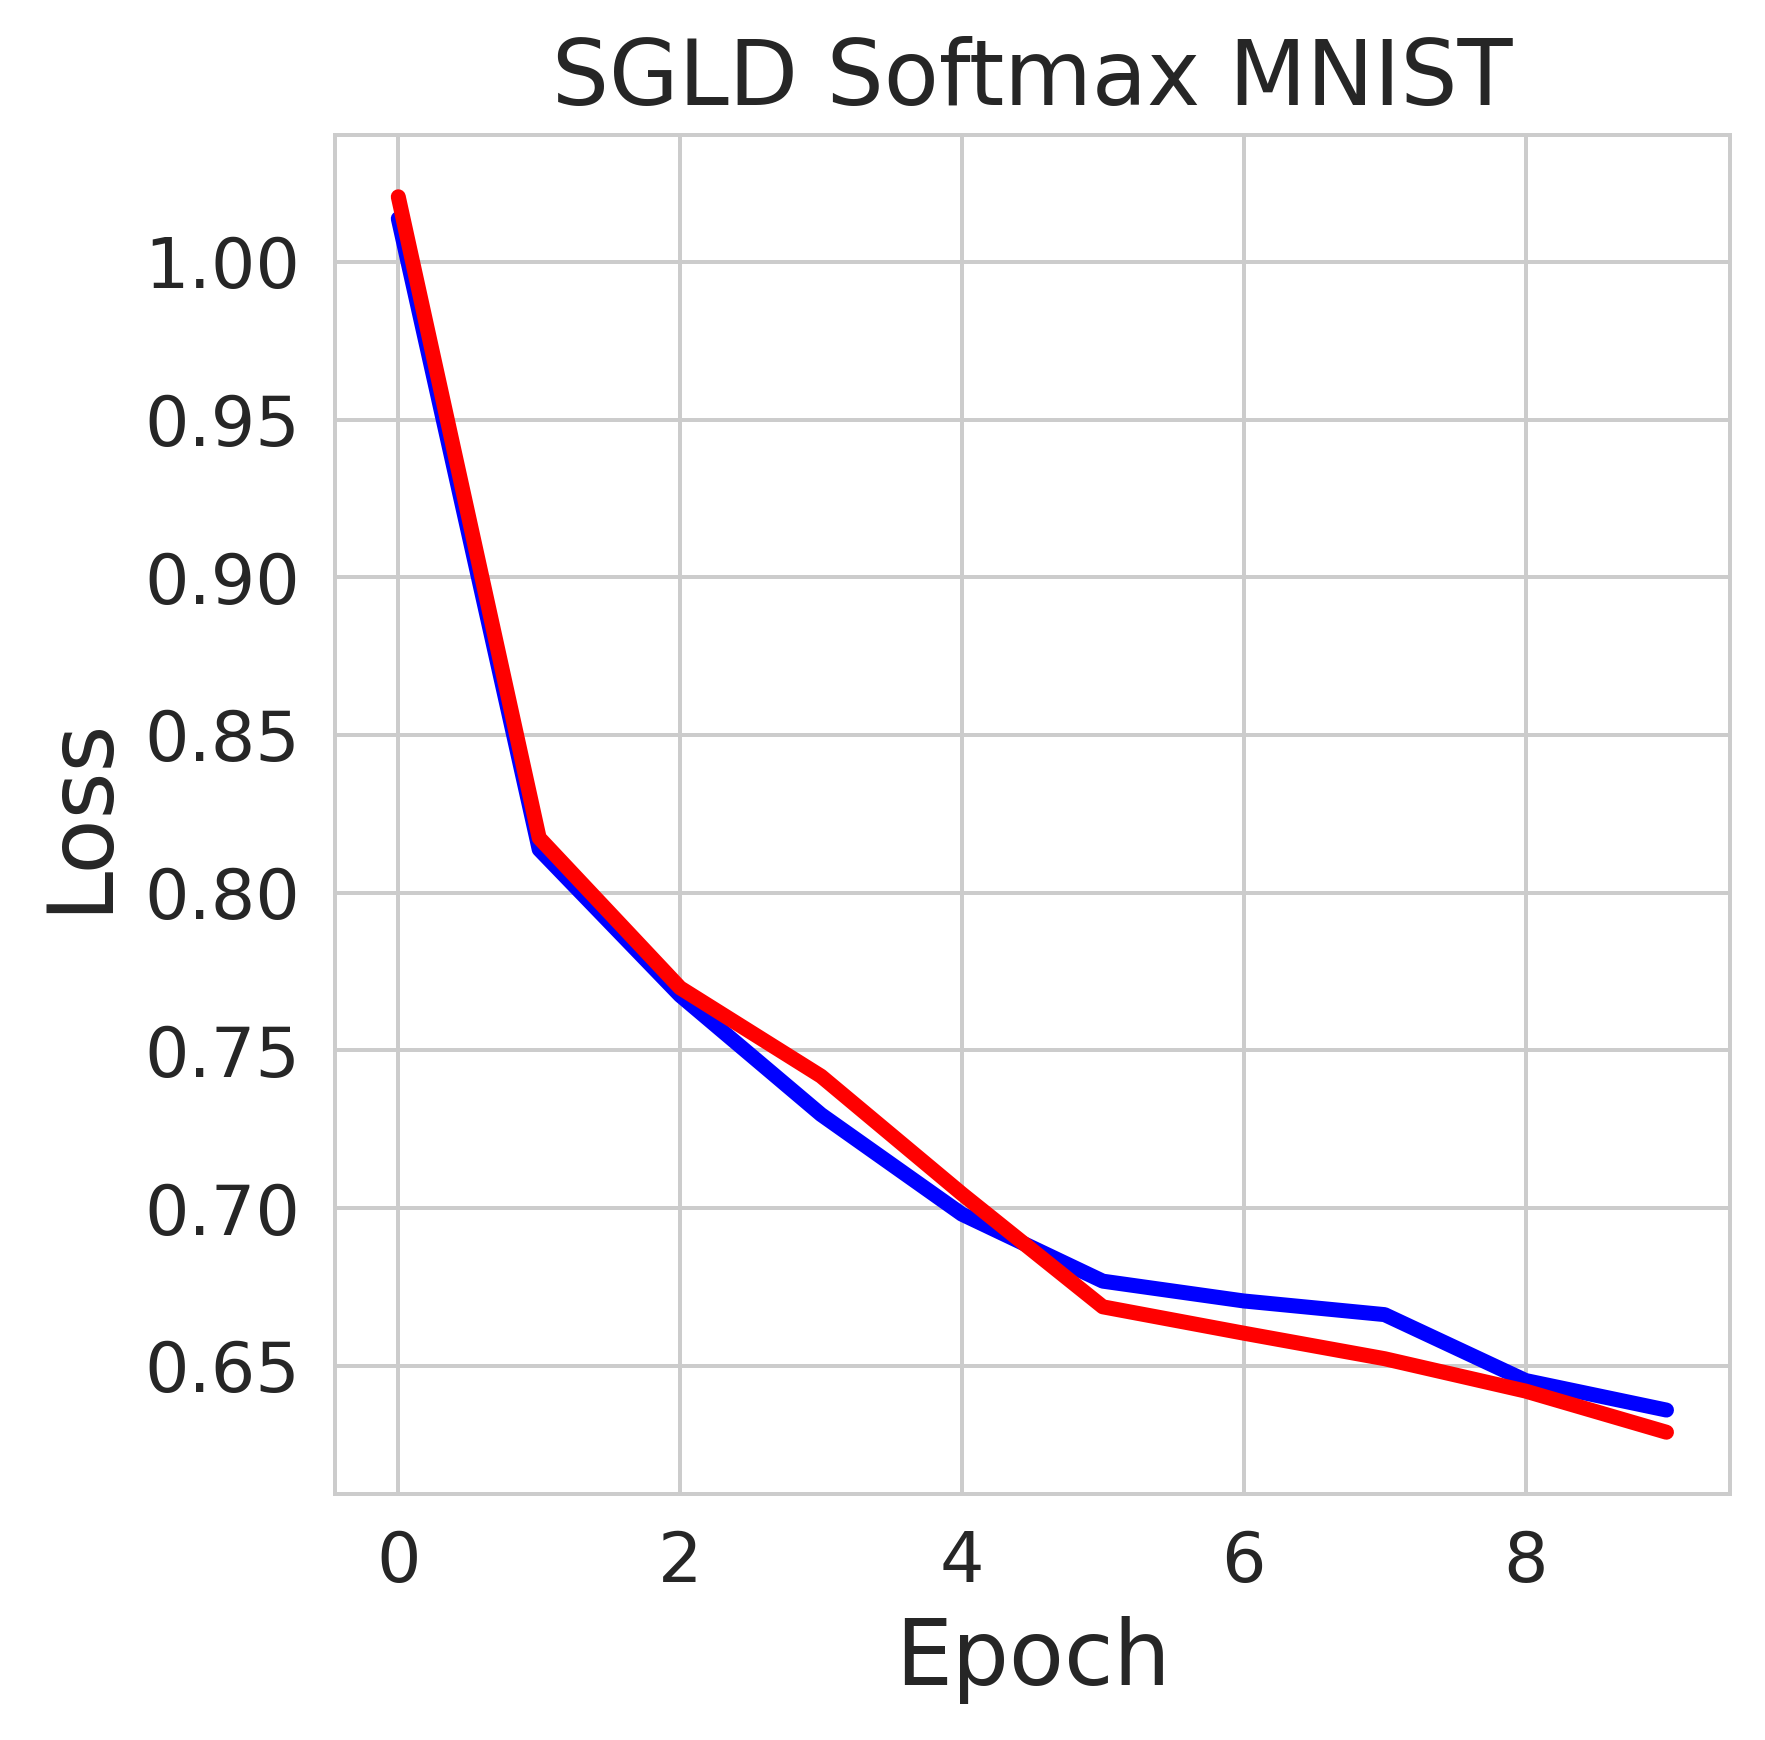

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 360
sns.set_style("whitegrid")


fig=plt.figure(figsize=[5,5])
plt.plot(loss[0],color='blue',lw=3)
plt.plot(loss[1],color='red',lw=3)
plt.xlabel('Epoch', size=18)
plt.ylabel('Loss', size=18)
plt.title('SGLD Softmax MNIST', size=18)
plt.xticks(size=14)
plt.yticks(size=14)
plt.savefig('sgld_softmax.pdf', bbox_inches='tight')

In [11]:
posterior_samples_flat=[item for sublist in posterior_samples for item in sublist]

In [13]:
total_samples,total_labels, log_like=inference.predict(posterior_samples_flat,5,data_loader=val_data)

In [14]:
from sklearn.metrics import classification_report
posterior_samples

y_hat=np.quantile(total_samples,.5,axis=0)

print(classification_report(np.int32(total_labels),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       980
           1       0.99      0.98      0.98      1135
           2       0.94      0.95      0.94      1032
           3       0.94      0.93      0.94      1010
           4       0.94      0.95      0.95       982
           5       0.91      0.97      0.94       892
           6       0.94      0.97      0.96       958
           7       0.94      0.92      0.93      1028
           8       0.93      0.93      0.93       974
           9       0.95      0.90      0.92      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



In [15]:
chains=len(posterior_samples)
posterior_samples_multiple_chains=list()
for i in range(chains):
    single_chain={var:list() for var in model.par}
    for file in posterior_samples[i]:
        model.net.load_parameters(file,ctx=model_ctx)
        for name,par in model.net.collect_params().items():
            single_chain[name].append(par.data().asnumpy())
    posterior_samples_single_chain={var:np.asarray(single_chain[var]) for var in single_chain}
    posterior_samples_multiple_chains.append(posterior_samples_single_chain)

In [16]:
import arviz as az

datasets=[az.convert_to_inference_data(sample) for sample in posterior_samples_multiple_chains]
dataset = az.concat(datasets, dim="chain")

In [17]:
az.summary(dataset)

arviz - WARNING - Array contains NaN-value.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"0.weight[0,0,0]",NaN,NaN,-3.466,NaN,NaN,NaN,NaN,NaN,NaN
"0.weight[0,0,1]",NaN,NaN,-2.355,NaN,NaN,NaN,NaN,NaN,NaN
"0.weight[0,0,2]",NaN,NaN,-2.130,NaN,NaN,NaN,NaN,NaN,NaN
"0.weight[0,0,3]",NaN,NaN,-2.398,NaN,NaN,NaN,NaN,NaN,NaN
"0.weight[0,0,4]",NaN,NaN,-3.887,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
6.weight[80],NaN,NaN,-1.541,NaN,NaN,NaN,NaN,NaN,NaN
6.weight[81],NaN,NaN,-1.335,NaN,NaN,NaN,NaN,NaN,NaN
6.weight[82],NaN,NaN,-2.017,NaN,NaN,NaN,NaN,NaN,NaN
6.weight[83],NaN,NaN,-1.670,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
mean_r_hat_values={var:float(az.rhat(dataset)[var].mean().data) for var in model.par}

In [52]:
print(mean_r_hat_values)

{'1.weight': 1.0340801293013426, '1.bias': 1.0001861857932042}


In [47]:
mean_ess_values={var:float(az.ess(dataset)[var].mean().data) for var in model.par}

In [48]:
print(mean_ess_values)

{'1.weight': 4242.692772026483, '1.bias': 6602.059991327962}

In [49]:
mean_mcse_values={var:float(az.mcse(dataset)[var].mean().data) for var in model.par}

In [53]:
print(mean_mcse_values)

{'1.weight': 0.028454770948850395, '1.bias': 0.022408065114994276}


# Bayes by Backprop <a class="anchor" id="chapter3"></a>

In [68]:
par={'weights':nd.random_normal(shape=(num_inputs,num_outputs),ctx=model_ctx),
     'bias':nd.random_normal(shape=num_outputs,ctx=model_ctx)}
hyper={'alpha':10.}

In [69]:
from hamiltonian.inference.bbb import bbb
from hamiltonian.models.softmax import softmax

model=mlp_softmax(hyper,in_units,out_units,4,32,ctx=model_ctx)
inference=bbb(model,model.par,step_size=0.05,ctx=model_ctx)

In [70]:
import importlib
import hamiltonian
importlib.reload(hamiltonian.models.softmax)
importlib.reload(hamiltonian.inference.bbb)

<module 'hamiltonian.inference.bbb' from '../hamiltonian/inference/bbb.py'>

In [71]:
par,loss,(means,sigmas)=inference.fit(epochs=10,batch_size=64,
                             X_train=X_train,y_train=y_train,
                             verbose=False)

100%|██████████| 10/10 [07:41<00:00, 46.12s/it]


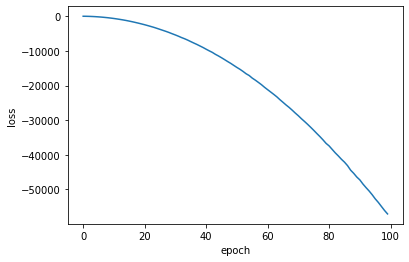

In [66]:
import matplotlib.pyplot as plt

plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [67]:
from sklearn.metrics import classification_report
import mxnet.gluon.probability as mxp

def softplus(x):
    return nd.log(1. + nd.exp(x))

posterior=dict()
for var in par.keys():
    variational_posterior=mxp.normal.Normal(loc=means[var],
                                            scale=softplus(sigmas[var]))
    posterior.update({var:variational_posterior})
    
samples=[]
for _ in range(100):
    post_par=dict()
    for var in par.keys():
        post_par.update({var:posterior[var].sample().as_nd_ndarray()})
    y_pred=model.predict(post_par,nd.array(X_test,ctx=model_ctx))
    samples.append(y_pred.sample().asnumpy())
samples=np.asarray(samples)
y_hat=np.quantile(samples,.5,axis=0)

print(classification_report(np.int32(y_test),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1425
           1       0.00      0.00      0.00      1564
           2       0.00      0.00      0.00      1438
           3       0.00      0.00      0.00      1442
           4       0.00      0.00      0.00      1366
           5       0.00      0.00      0.00      1244
           6       0.10      0.83      0.18      1363
           7       0.21      0.35      0.26      1429
           8       0.04      0.01      0.01      1342
           9       0.00      0.00      0.00      1387

    accuracy                           0.12     14000
   macro avg       0.03      0.12      0.05     14000
weighted avg       0.03      0.12      0.05     14000



# Posterior Diagnostics <a class="anchor" id="chapter4"></a>

In [36]:
import arviz as az

In [39]:
np.expand_dims(np.asarray([posterior_samples['0.bias'][0].asnumpy() for sample in posterior_samples['0.bias']]),0).shape

(1, 30, 10)

In [40]:
posterior_samples_numpy=dict()

for var in posterior_samples.keys():
    posterior_samples_numpy.update(
        {var:np.expand_dims(np.asarray(
            [sample.asnumpy() for sample in posterior_samples[var]]),0)
        })


In [58]:
posterior_samples_numpy['0-weights'].shape

(1, 5, 784, 10)

In [59]:
dataset = az.convert_to_inference_data(posterior_samples_numpy)

In [60]:
ess=az.ess(dataset)

In [61]:
ess

<xarray.Dataset>
Dimensions:        (bias_dim_0: 10, weights_dim_0: 784, weights_dim_1: 10)
Coordinates:
  * weights_dim_0  (weights_dim_0) int64 0 1 2 3 4 5 ... 778 779 780 781 782 783
  * weights_dim_1  (weights_dim_1) int64 0 1 2 3 4 5 6 7 8 9
  * bias_dim_0     (bias_dim_0) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    weights        (weights_dim_0, weights_dim_1) float64 4.0 4.0 ... 4.0 4.0
    bias           (bias_dim_0) float64 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0 4.0

In [62]:
az.summary(dataset)

arviz - WARNING - Shape validation failed: input_shape: (1, 5), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"weights[0,0]",1.862,0.0,1.862,1.862,0.0,0.0,4.0,4.0,NaN
"weights[0,1]",-2.258,0.0,-2.258,-2.258,0.0,0.0,4.0,4.0,NaN
"weights[0,2]",-1.389,0.0,-1.389,-1.389,0.0,0.0,4.0,4.0,NaN
"weights[0,3]",-1.668,0.0,-1.668,-1.668,0.0,0.0,4.0,4.0,NaN
"weights[0,4]",-1.602,0.0,-1.602,-1.602,0.0,0.0,4.0,4.0,NaN
...,...,...,...,...,...,...,...,...,...
bias[5],0.509,0.0,0.509,0.509,0.0,0.0,4.0,4.0,NaN
bias[6],-0.058,0.0,-0.058,-0.058,0.0,0.0,4.0,4.0,NaN
bias[7],0.362,0.0,0.362,0.362,0.0,0.0,4.0,4.0,NaN
bias[8],-0.409,0.0,-0.409,-0.409,0.0,0.0,4.0,4.0,NaN


In [63]:
784*10+10

7850